# Example: Memory kernel calculation using projection operator method

In this notebook I demonstrate how to calculate memory kernels for surface site fluctuations of a solid lattice using the project operator approach.  


In [13]:
from ase.build import fcc111
from asap3 import EMT
from ase.visualize import view
from ase import units
from ase.vibrations import Vibrations
from ase.optimize import BFGS

import os
import numpy as np
import matplotlib.pyplot as plt
from glepy.memory.proj import BathProjection

##### Script Parameters

# number of atoms along each lattice direction
Nx, Ny, Nz = 4,4,4

# indices to keep fixed during vib calculations
indices_fixed = [0,Nx-1,Nx*Ny-Nx,Nx*Ny-1] # indices to keep fixed

# time axis arguments
Nt = 3000
dt = 0.025 

## Create Solid Lattice

In [15]:
# Delete All Files in Directory
dir = './vib/'
if os.path.isdir(dir) == False:
    os.mkdir(dir)

for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

##### Define some useful variables

# Some useful variables
Nsurface = Nx*Ny
Nlattice = Nx*Ny*Nz - len(indices_fixed)
Ndof = Nlattice * 3
tarr = np.arange(Nt) * dt

# indices to use to calculate memory kernel (surface sites)
indices_calc  = ((Nz-1)*Ny*Nx - len(indices_fixed)) + np.arange(Nx*Ny)

# indices allowed to vibrate during calculation
indices_free = np.delete(np.arange(Nx*Ny*Nz),indices_fixed)

# Create Lattice
atoms = fcc111('Pt', orthogonal=True, size=(Nx, Ny, Nz))
atoms.center(axis=2, vacuum=10)
atoms.translate([0, 0, -10])
atoms.pbc=(True, True, False)

# Describe the interatomic interactions with the Effective Medium Theory
# Set calculator (EMT)
try:
    from asap3 import EMT
    calc = EMT()
    calc.set_atoms(atoms)
    atoms.calc   = calc
    print("Using ASAP EMT calculator")
except:
    print("ASAP not installed defaulting to ase emt")
    from ase.calculators.emt import EMT
    calc = EMT
    calc.set_atoms(atoms)
    atoms.calc   = calc

Using ASAP EMT calculator


## Minimize PE and run Hessian calculation

In [23]:
# Minimize Energy
BFGS(atoms).run(fmax=0.005)

# Calculate Hessian
vib = Vibrations(atoms,indices=indices_free)
vib.run()
vib.summary(method='Frederiksen')

# Extract hessian and convert from ASE time units to 1/ps
t_convert = (1e-12) / ( 1e-10 * np.sqrt(units._amu/units._e) )
H = vib.H * (t_convert**2)
masses = atoms.get_masses()[indices_free]

      Step     Time          Energy         fmax
BFGS:    0 22:14:00        9.917770        0.0003
---------------------
  #    meV     cm^-1
---------------------
  0    1.6      12.7
  1    1.6      13.2
  2    2.2      17.5
  3    4.1      33.0
  4    4.2      33.8
  5    4.7      37.8
  6    4.9      39.2
  7    5.8      46.7
  8    5.8      47.0
  9    5.8      47.2
 10    5.9      47.4
 11    6.3      50.7
 12    6.3      50.8
 13    6.5      52.3
 14    6.5      52.8
 15    6.6      53.1
 16    6.7      53.7
 17    6.7      54.2
 18    6.7      54.3
 19    7.0      56.2
 20    7.0      56.5
 21    7.5      60.5
 22    7.6      61.1
 23    7.6      61.2
 24    7.7      62.0
 25    8.0      64.1
 26    8.0      64.3
 27    8.0      64.9
 28    8.1      65.4
 29    8.1      65.4
 30    8.1      65.6
 31    8.1      65.7
 32    8.2      65.9
 33    8.2      66.0
 34    8.2      66.2
 35    8.2      66.3
 36    8.3      66.6
 37    8.3      66.9
 38    8.4      67.4
 39    8.4      6

## Calculate memory kernel on each surface site

In [29]:
# Kt - memory kernel in time domain
# Kw - memory kernel in frequency domain
# freq  - bath phonon frequencies
# frck  - bath-normalized surface site force constant

Kt_arr, Kw_arr, freqs_arr, frck_arr  = [], [], [], []

for i in indices_calc:
    print(i)

    # select indices of surface site degrees of freedom
    indx_P = np.arange(3*i,3*i+3)

    # initialize projection operator (po) object
    po = BathProjection(H,masses,indx_P)

    # calculate relevant quantities
    Kt = po.calc_memory(tarr)
    Kw = po.calc_spectraldensity()
    freqs = po.freq
    frck = po.calc_springk()

    #append to arrays
    Kt_arr.append(Kt)
    Kw_arr.append(Kw)
    freqs_arr.append(freqs)
    frck_arr.append(frck)
    
# make lists into numpy arrays
Kt_arr, Kw_arr, freqs_arr, frck_arr  = map(np.array,[Kt_arr, Kw_arr, freqs_arr, frck_arr])

# average results 
Kt_x, Kt_y, Kt_z = np.mean(Kt_arr[:,:,0,0],axis=0), np.mean(Kt_arr[:,:,1,1],axis=0), np.mean(Kt_arr[:,:,2,2],axis=0)

44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


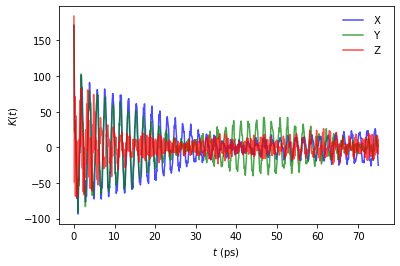

In [30]:
##### Plot results
plt.figure()
plt.plot(tarr, Kt_x, label=" X ", color="blue", alpha=0.7)
plt.plot(tarr, Kt_y, label=" Y ", color="green", alpha=0.7)
plt.plot(tarr, Kt_z, label=" Z ", color="red", alpha=0.7)
plt.ylabel(r"$K(t)$")
plt.xlabel("$t$ (ps)")
plt.legend(frameon=False)